Starting Portfolio Value: 100000.00
BUY 18590 shares at 5.11
1999-05-14, BUY EXECUTED, 5.25
SELL shares at 8.64
1999-07-13, SELL EXECUTED, 8.51
BUY 5479 shares at 27.8
2000-04-17, BUY EXECUTED, 26.91
SELL shares at 36.33
2000-06-14, SELL EXECUTED, 36.41
BUY 6648 shares at 30.3
2000-10-05, BUY EXECUTED, 30.38
SELL shares at 17.42
2001-07-03, SELL EXECUTED, 17.25
BUY 8153 shares at 14.5
2001-08-09, BUY EXECUTED, 14.52
SELL shares at 14.85
2002-01-11, SELL EXECUTED, 14.85
BUY 10754 shares at 11.21
2002-03-18, BUY EXECUTED, 11.41
SELL shares at 11.57
2003-01-10, SELL EXECUTED, 11.26
BUY 12412 shares at 9.57
2003-03-11, BUY EXECUTED, 9.62
SELL shares at 11.48
2003-05-16, SELL EXECUTED, 11.48
BUY 13128 shares at 10.7
2003-09-24, BUY EXECUTED, 10.70
SELL shares at 12.1
2004-01-07, SELL EXECUTED, 12.16
BUY 14004 shares at 11.31
2004-03-08, BUY EXECUTED, 11.44
SELL shares at 11.39
2004-11-03, SELL EXECUTED, 11.52
BUY 13827 shares at 11.51
2005-02-22, BUY EXECUTED, 11.35
SELL shares at 12.06
200

<IPython.core.display.Javascript object>


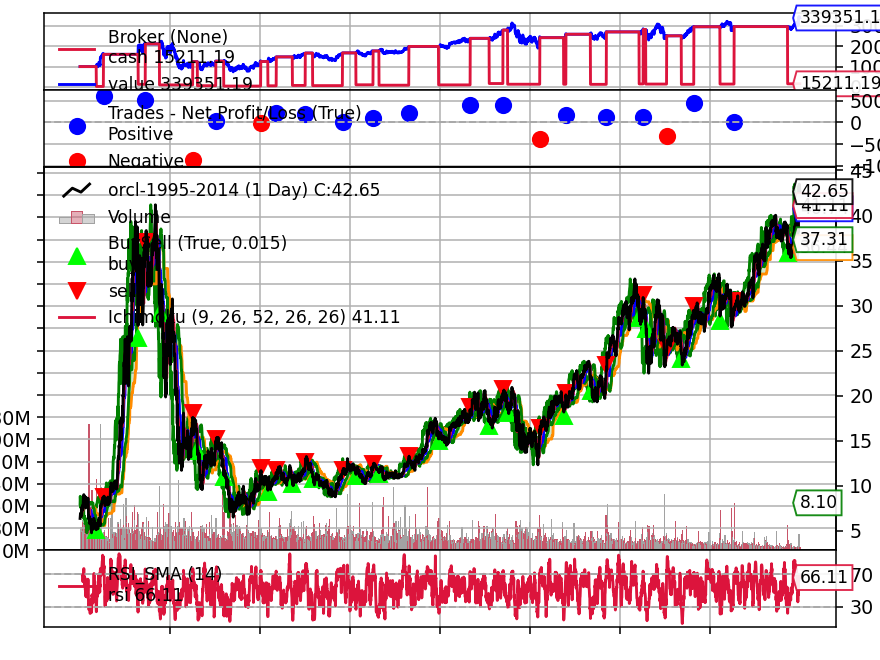

In [3]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import math 

# Import the backtrader platform
import backtrader as bt

class RSI(bt.Strategy) :
    params =(('period',14),('percent',0.95),('overbought',70),('oversold',30))
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def __init__ (self) :
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period= self.params.period)
        self.ishimoku = bt.indicators.Ichimoku()
        self.spanA = self.ishimoku.lines.senkou_span_a
        self.spanB = self.ishimoku.lines.senkou_span_b
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    
    def next(self) :   
        # Checking whether the stock is oversold or over bought and then using Ichimoku Cloud
        if not self.position and self.rsi < self.params.oversold:
            # Checking whether the trend is negative(red cloud) and then,if its green cloud,whether the close is below the cloud
            if self.spanA < self.spanB or (self.spanA > self.spanB and self.data.close[0] < self.spanB) :
                self.numShares = math.floor(self.broker.cash * self.params.percent/self.data.close)
    #             self.numShares = 100

                print("BUY {} shares at {}".format(self.numShares,self.data.close[0]))
                self.buy(size = self.numShares)
            
        if self.position and self.rsi > self.params.overbought:
            #Checking if its upward trend(green cloud) and whether the close value above the green cloud
            if self.spanA > self.spanB or (self.spanA > self.spanB and self.data.close[0] > self.spanA) :
                print('SELL shares at {}'.format(self.data.close[0]))
                self.close()

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(RSI)
    name = ['orcl-1995-2014.txt','nvda-1999-2014.txt','yhoo-1996-2014.txt','AAPL.txt']

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname= name[0],
        # Do not pass values before this date
        fromdate=datetime.datetime(1999, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2014, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.001)
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.plot()